In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from helpers import *
from scipy.ndimage import gaussian_filter

FileNotFoundError: [Errno 2] No such file or directory: 'simulations/data/test_similarities/pv_corr_vs_similarity_a_inh_plast_False_lrinh_False_sim_0/a_0.0_top_down_False_plasticity_False.pkl'

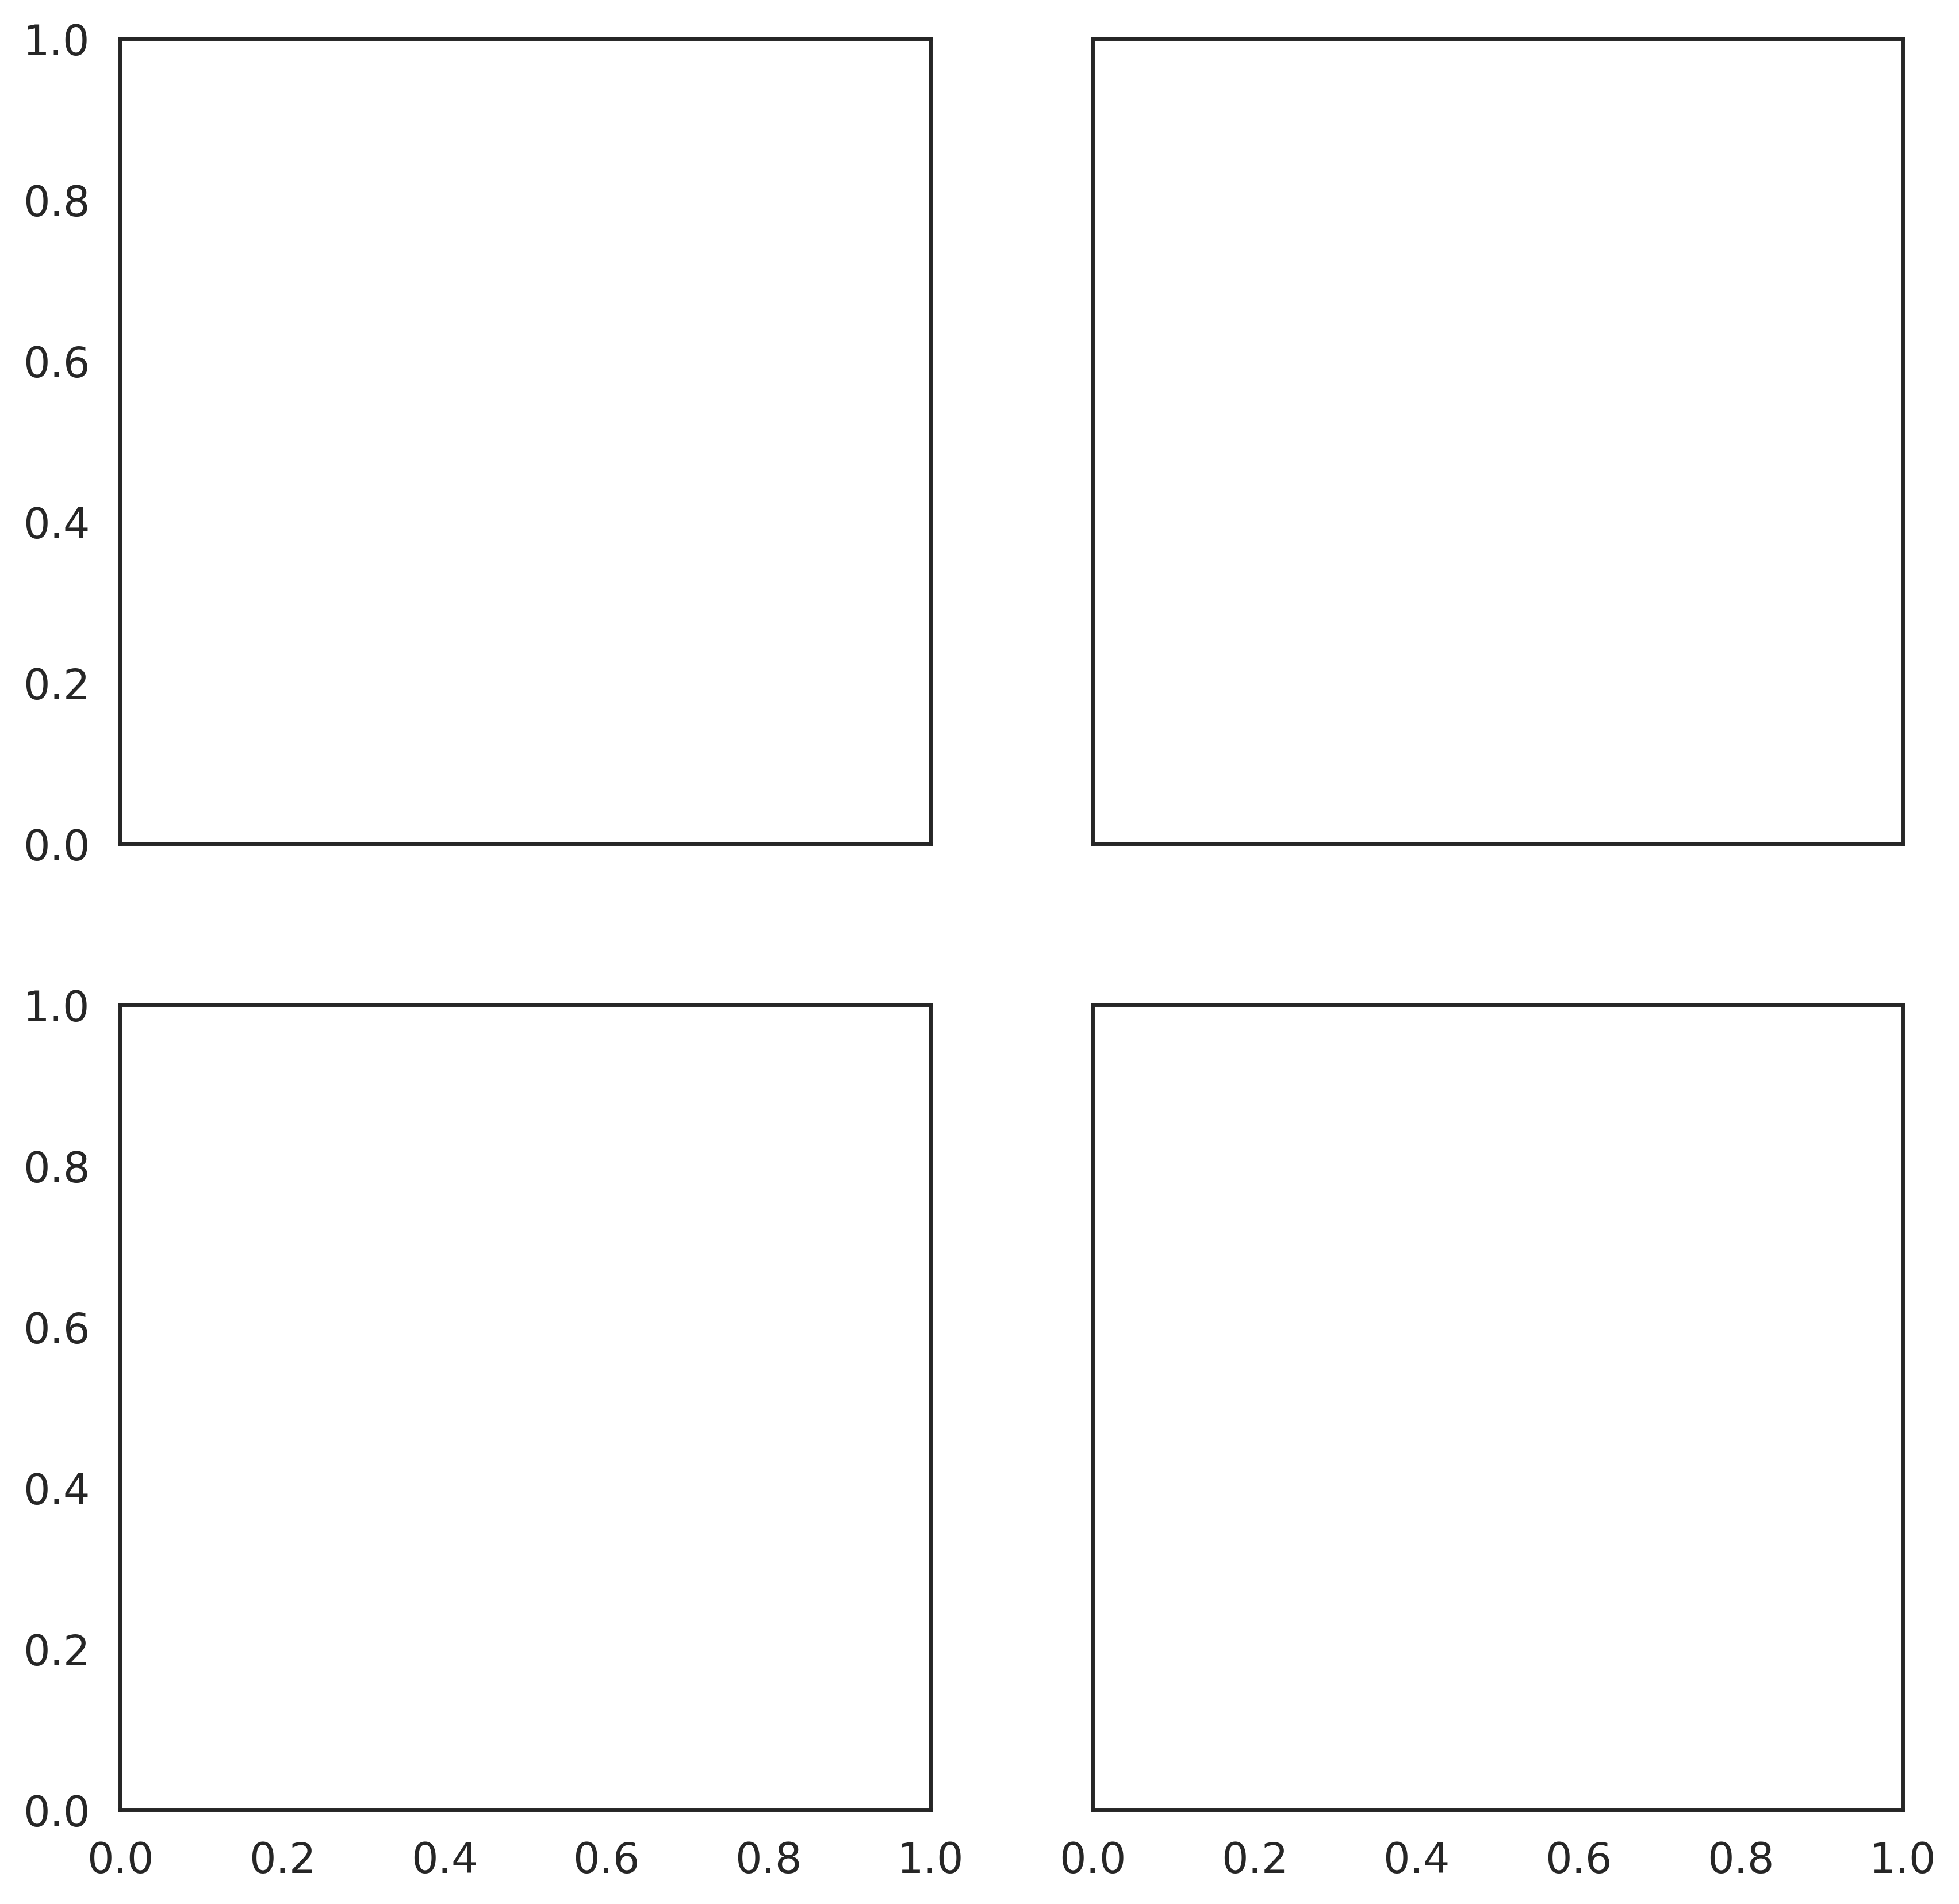

In [ ]:
### plots the PV correlation coefficients over different values of a 
### and different learning rules

sns.set(style="white", font_scale=1.2)

fs = 25

viridis_palette = sns.color_palette("viridis", 4)
COLORS = {
    ('False', 'False'): viridis_palette[0],
    ('True', 'True'): viridis_palette[2],
    ('False', 'True'): viridis_palette[3],
    'CA3': 'orange'  # Keep CA3 as orange for contrast
}

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True, dpi=400)
axs = axs.flatten()  # Flatten the 2D array of axes for easier iteration

for idx, inh_plast in enumerate(['False_lrinh_False', 'True_lrinh_1', 'True_lrinh_10', 'True_lrinh_100']):
    # TODO: Maybe i'll mash these two together into one plot
    all_cors = {'False_False': [], 'True_True': [], 'False_True': []}
    all_cors_ca3 = []
    ax = axs[idx]
    

    for i in range(50): 
        cors, cors_ca3 = {}, []
        aas = np.arange(0, 1.1, 0.1).round(1)  # Use the same aas for all simulations

        for key in all_cors.keys():
            cors[key] = []
            for a in aas:
            
                k1, k2 = key.split('_')
                with open(f"simulations/data/test_similarities/pv_corr_vs_similarity_a_inh_plast_{inh_plast}_sim_{i}/a_{a}_top_down_{k1}_plasticity_{k2}.pkl", 'rb') as f:
                # with open(f"../plots/test_similarities/pv_corr_vs_similarity_inh_plast_{inh_plast}_sim_{i}.pkl", 'rb') as f:
                    results = pickle.load(f)
                cors[key].append(np.nanmean(results[0]))
                if key == 'False_False':
                    cors_ca3.append(np.nanmean(results[1]))

        for key in cors:
            all_cors[key].append(cors[key])
        all_cors_ca3.append(cors_ca3)

    # fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
    for j, (key_str, cor_list) in enumerate(all_cors.items()):
        k1, k2 = key_str.split('_')
        color = COLORS[(k1, k2)]

        print(np.array(cor_list).shape)

        m = np.nanmean(cor_list, axis=0)
        sem = np.nanstd(cor_list, axis=0) / np.sqrt(len(cor_list))
    
        label = ['no 2nd map learning', 'hebbian+topdown', 'hebbian'][j] if idx == 0 else None
        ax.plot(aas, m, label=label, color=color, linewidth=2)
        ax.fill_between(aas, m - sem, m + sem, color=color, alpha=0.2)
        ax.set_ylabel(' ', fontsize=fs)  # Clear ylabel for all but the first subplot

    # Add CA3 as a baseline (no SEM, since not averaged)
    label = 'CA3' if idx == 0 else None
    ax.plot(aas, np.mean(all_cors_ca3, axis=0), label=label, color=COLORS['CA3'], linestyle='--', linewidth=2)

    # Aesthetic settings
    if idx > 1:
        ax.set_xlabel('Input similarity (a)', fontsize=fs)
    plast_str = '0' if inh_plast.split('_')[2] == 'False' else inh_plast.split('_')[2]
    ax.set_title(r'$\eta_{inh} = ' + (plast_str)  + r'$', fontsize=fs)
    ax.set_xticks([0,.5,1])
    ax.set_yticks([0, 0.5, 1])
    ax.set_xticklabels([0, .5, 1], fontsize=fs//1.3)
    ax.set_yticklabels([0, .5, 1], fontsize=fs//1.3)
    ax.hlines([0], xmin=-.05, xmax=1, color='black', linestyle='--', linewidth=1.5)
    ax.set_ylim(-0.1, 1.05)
    ax.set_xlim(-.05, 1)

axs[0].set_ylabel('PV Cor. Coeff.', fontsize=fs)
axs[2].set_ylabel('PV Cor. Coeff.', fontsize=fs)


fig.legend(frameon=False, loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1, fontsize=fs//1.3)
sns.despine()
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at bottom for the legend
plt.show()
plt.close()


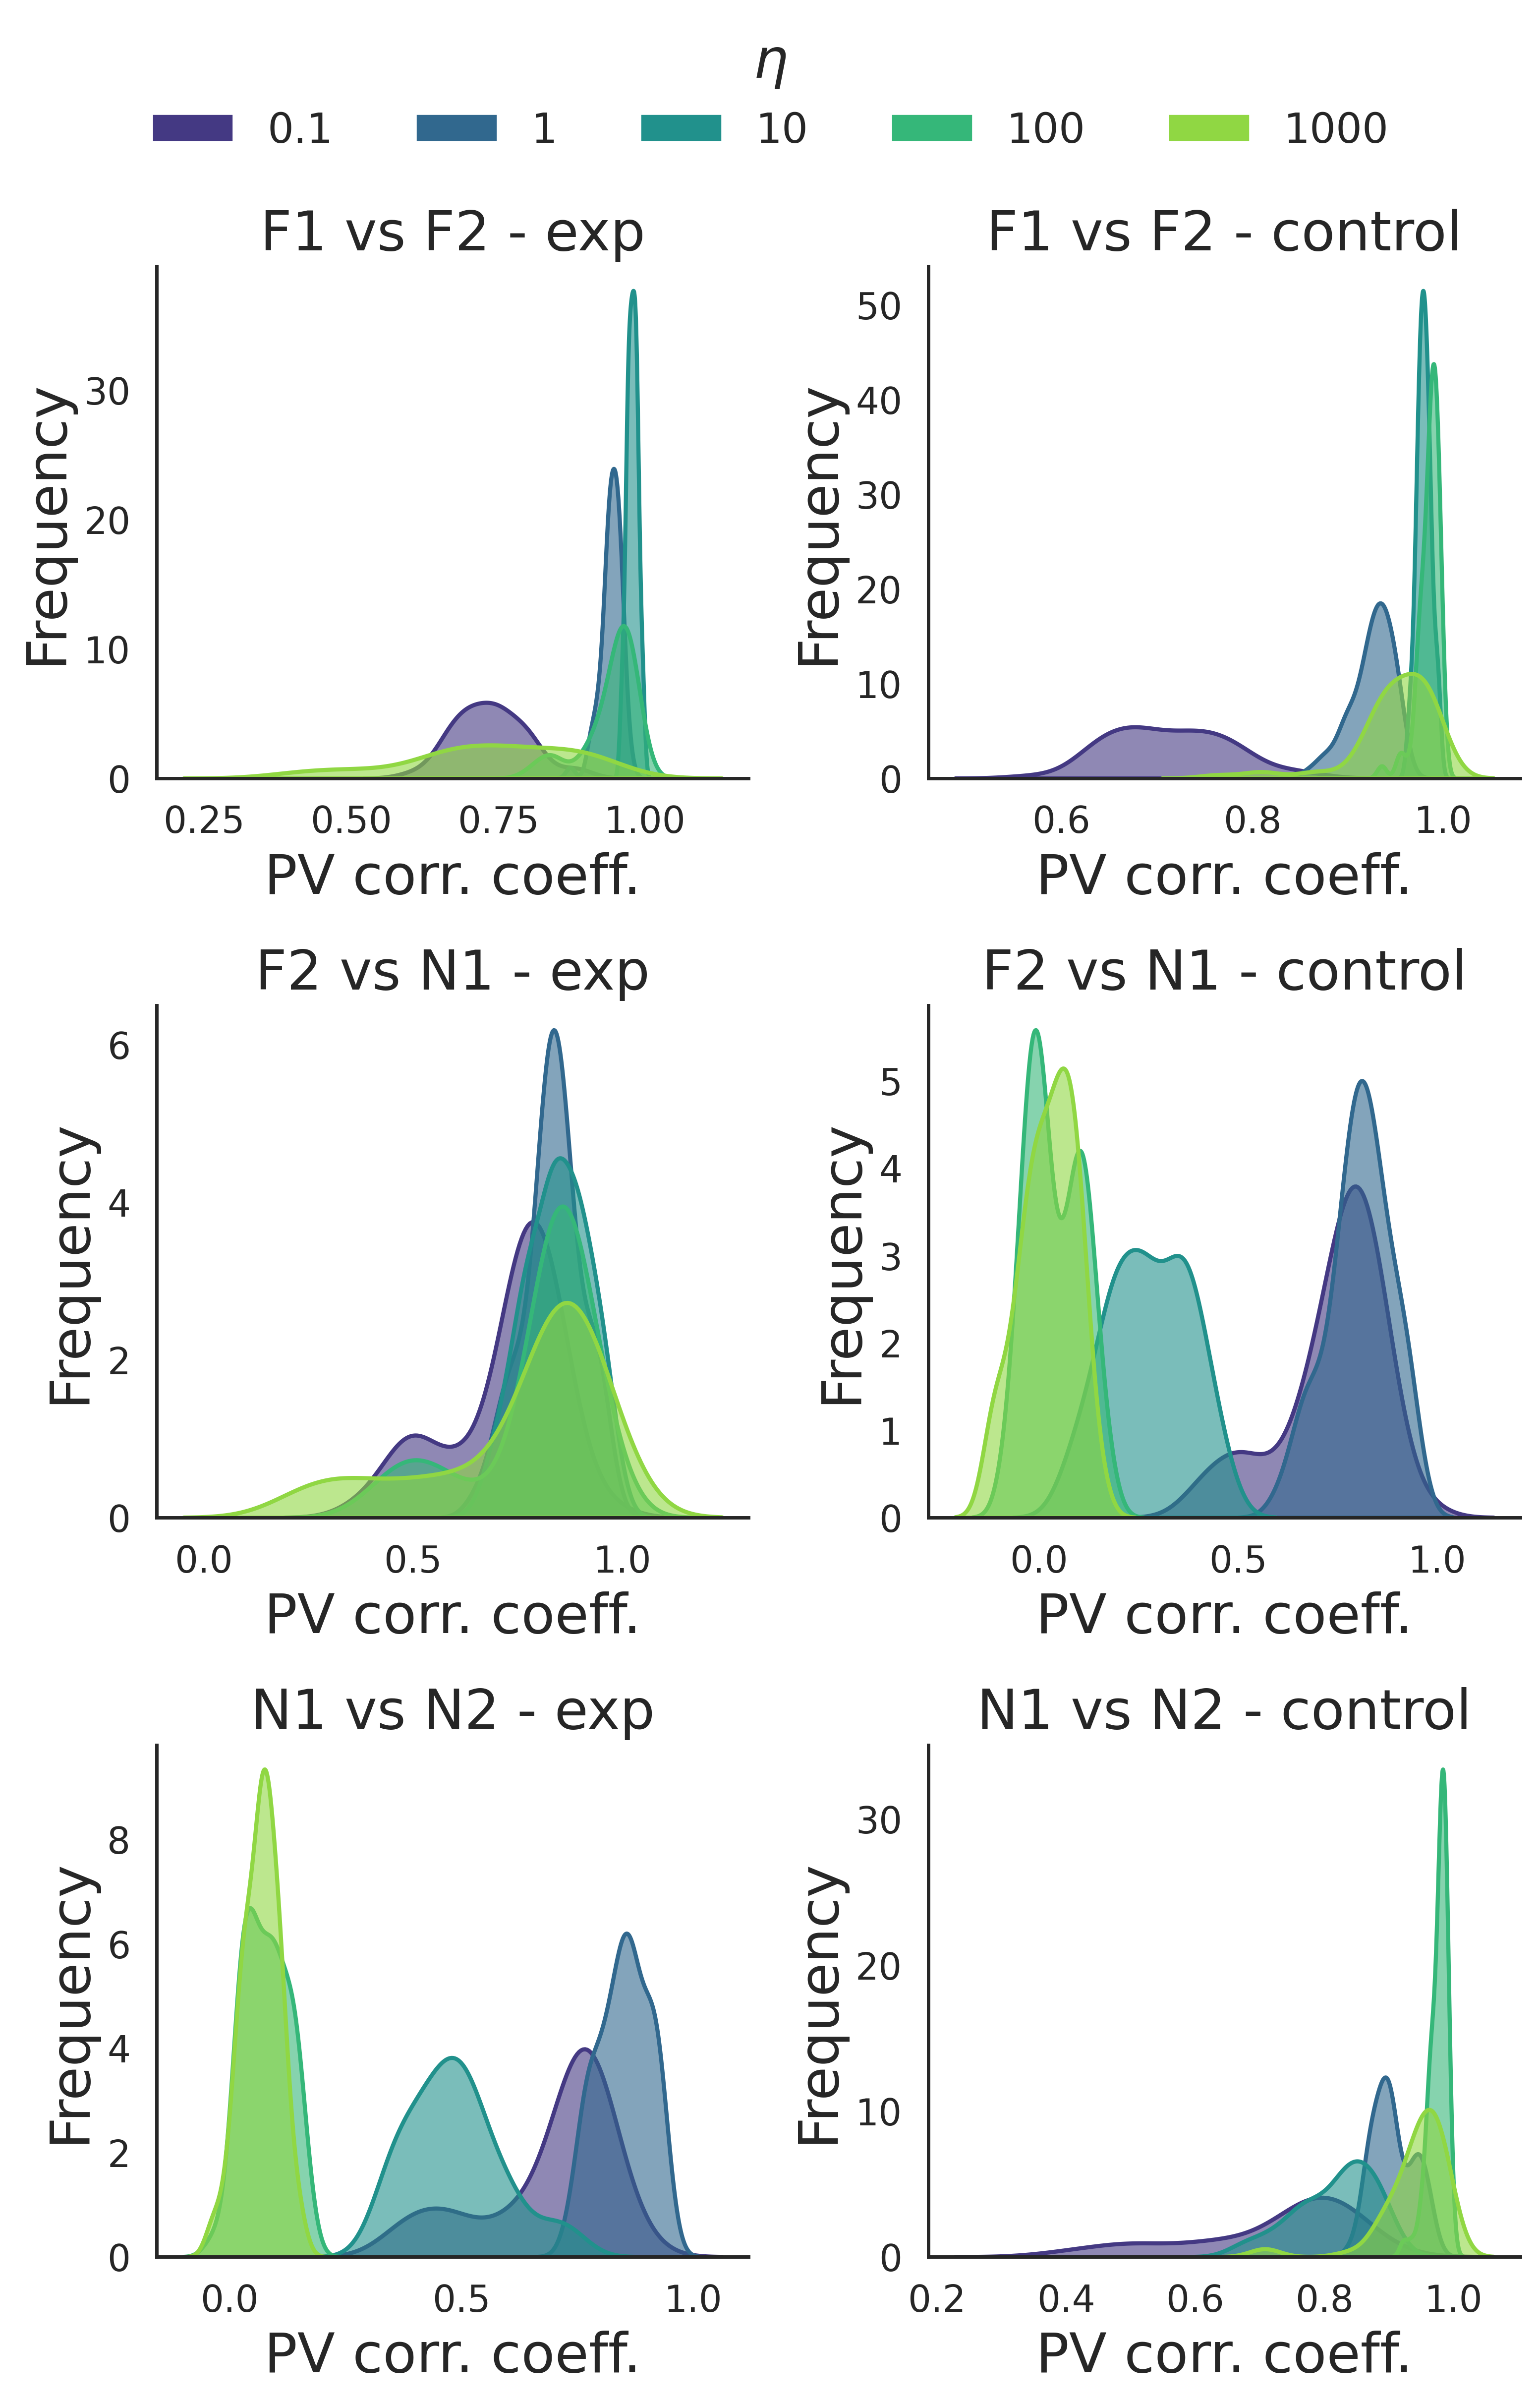

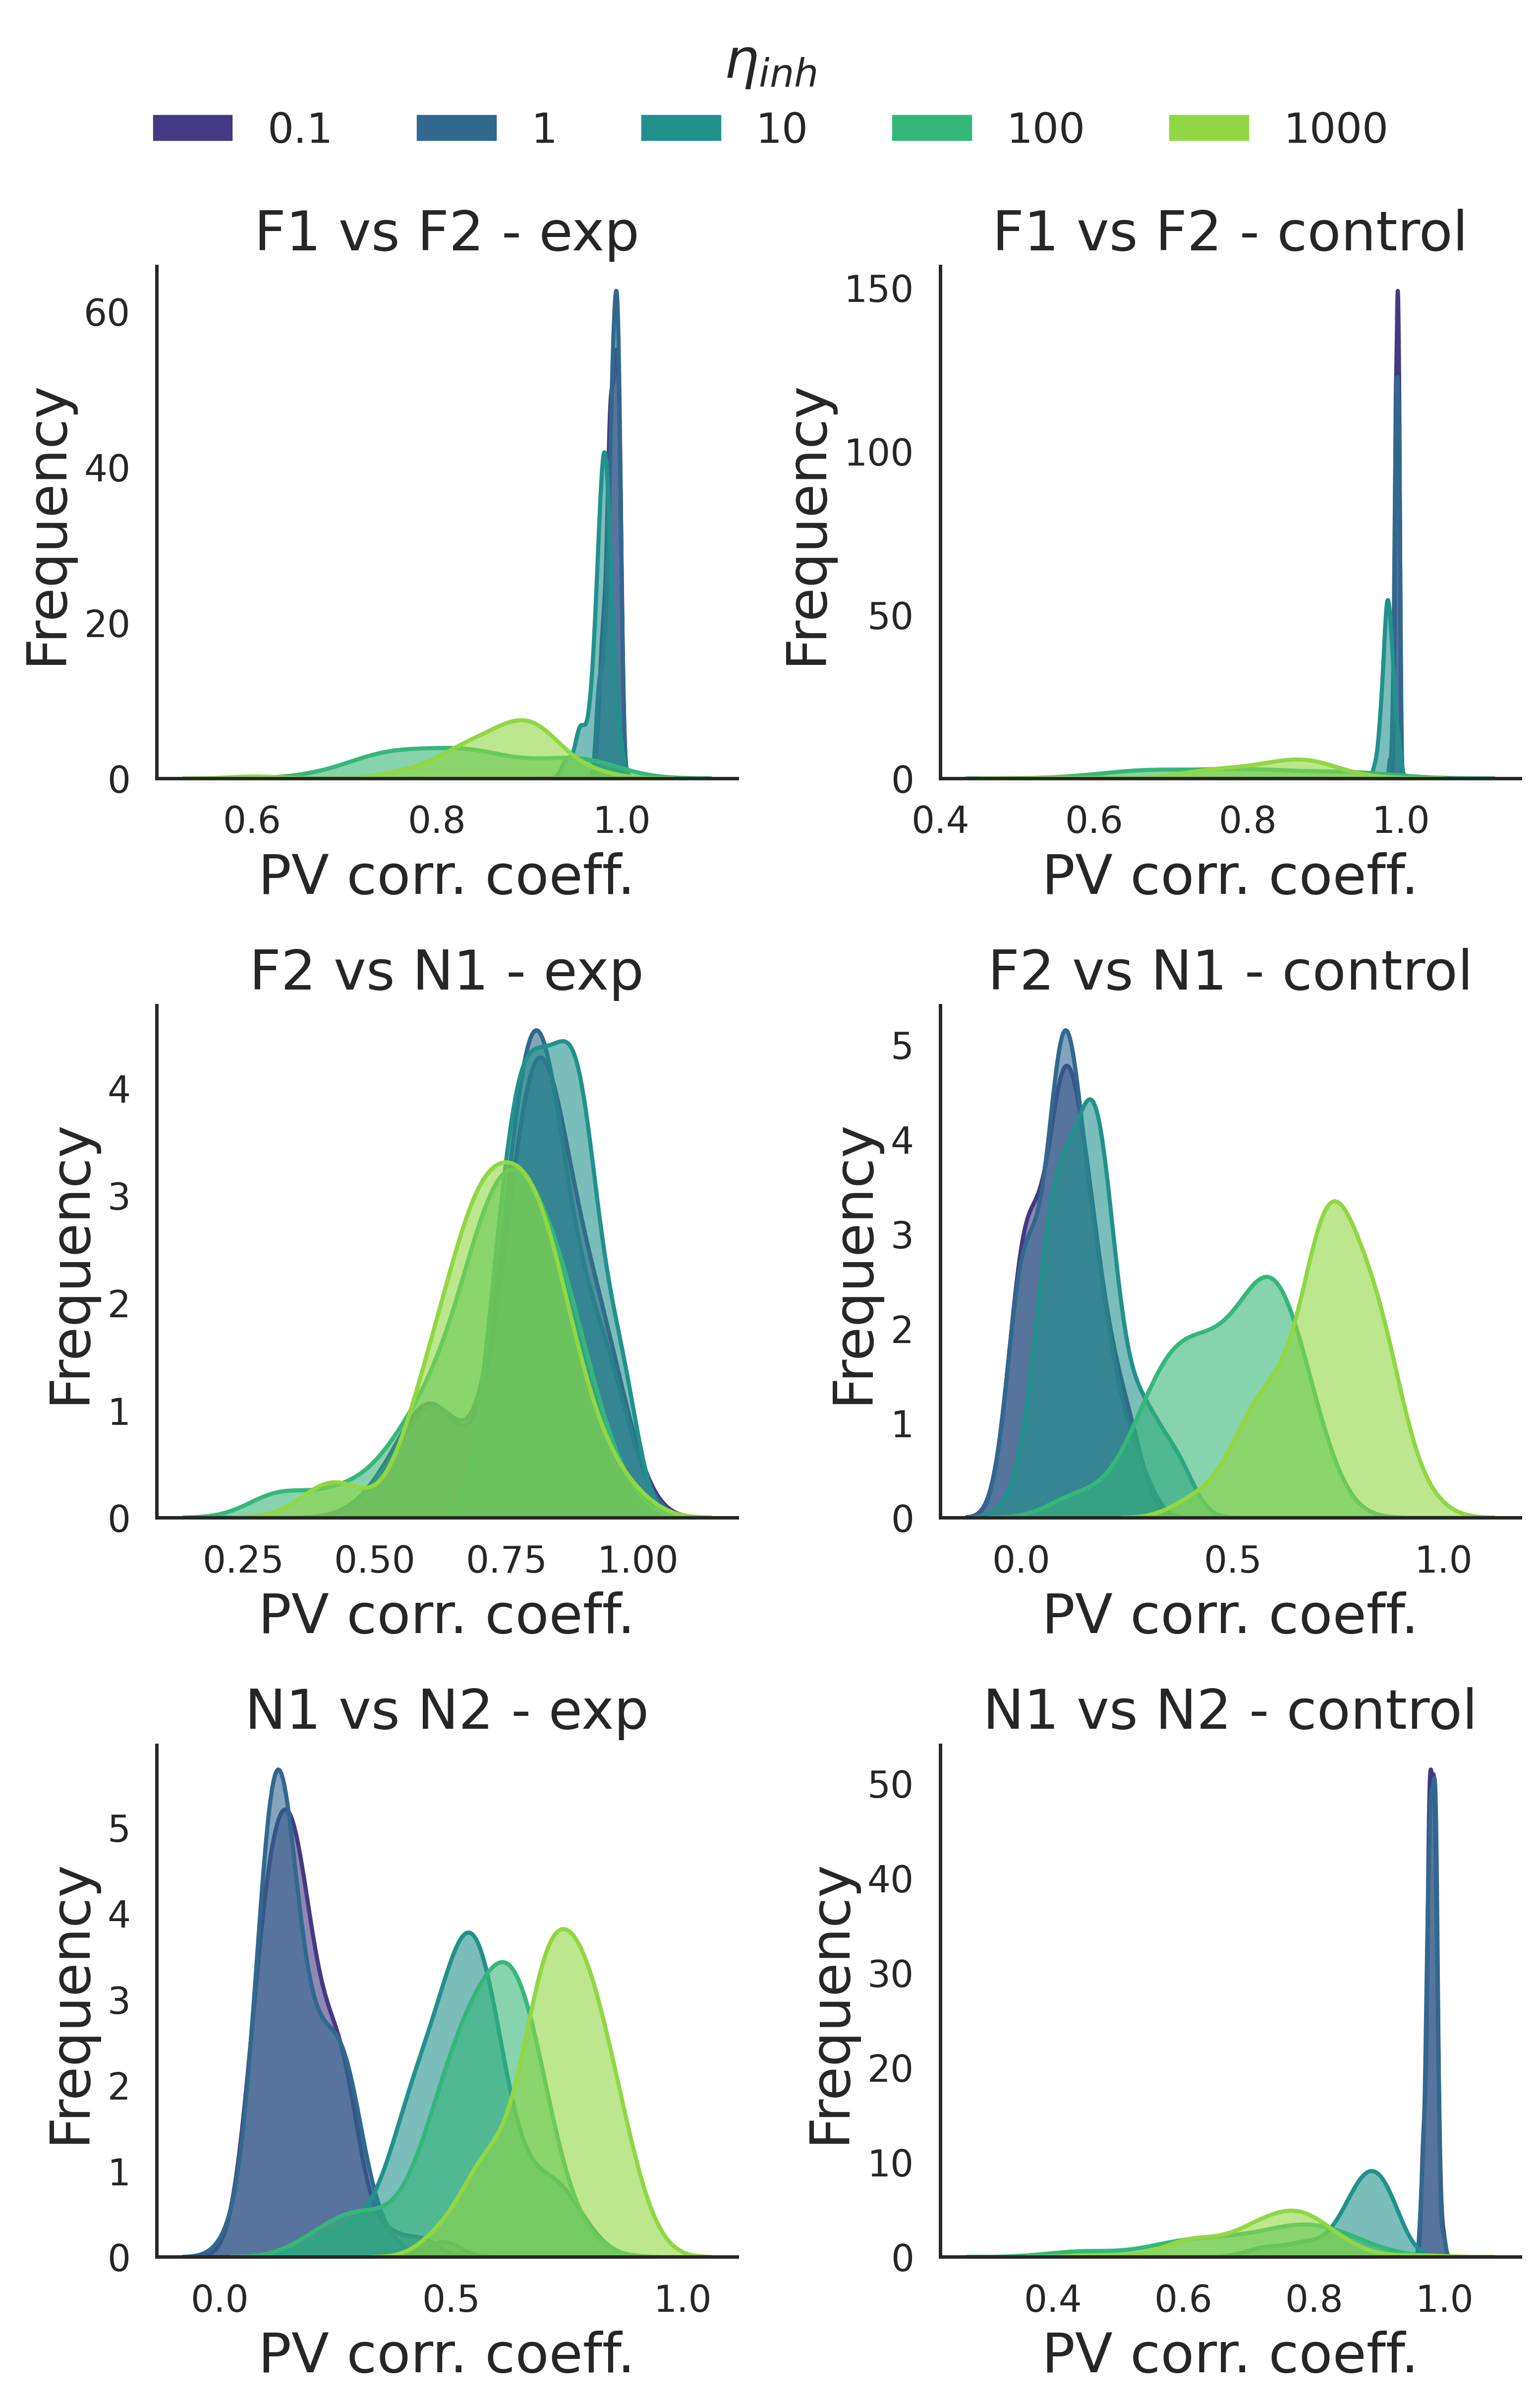

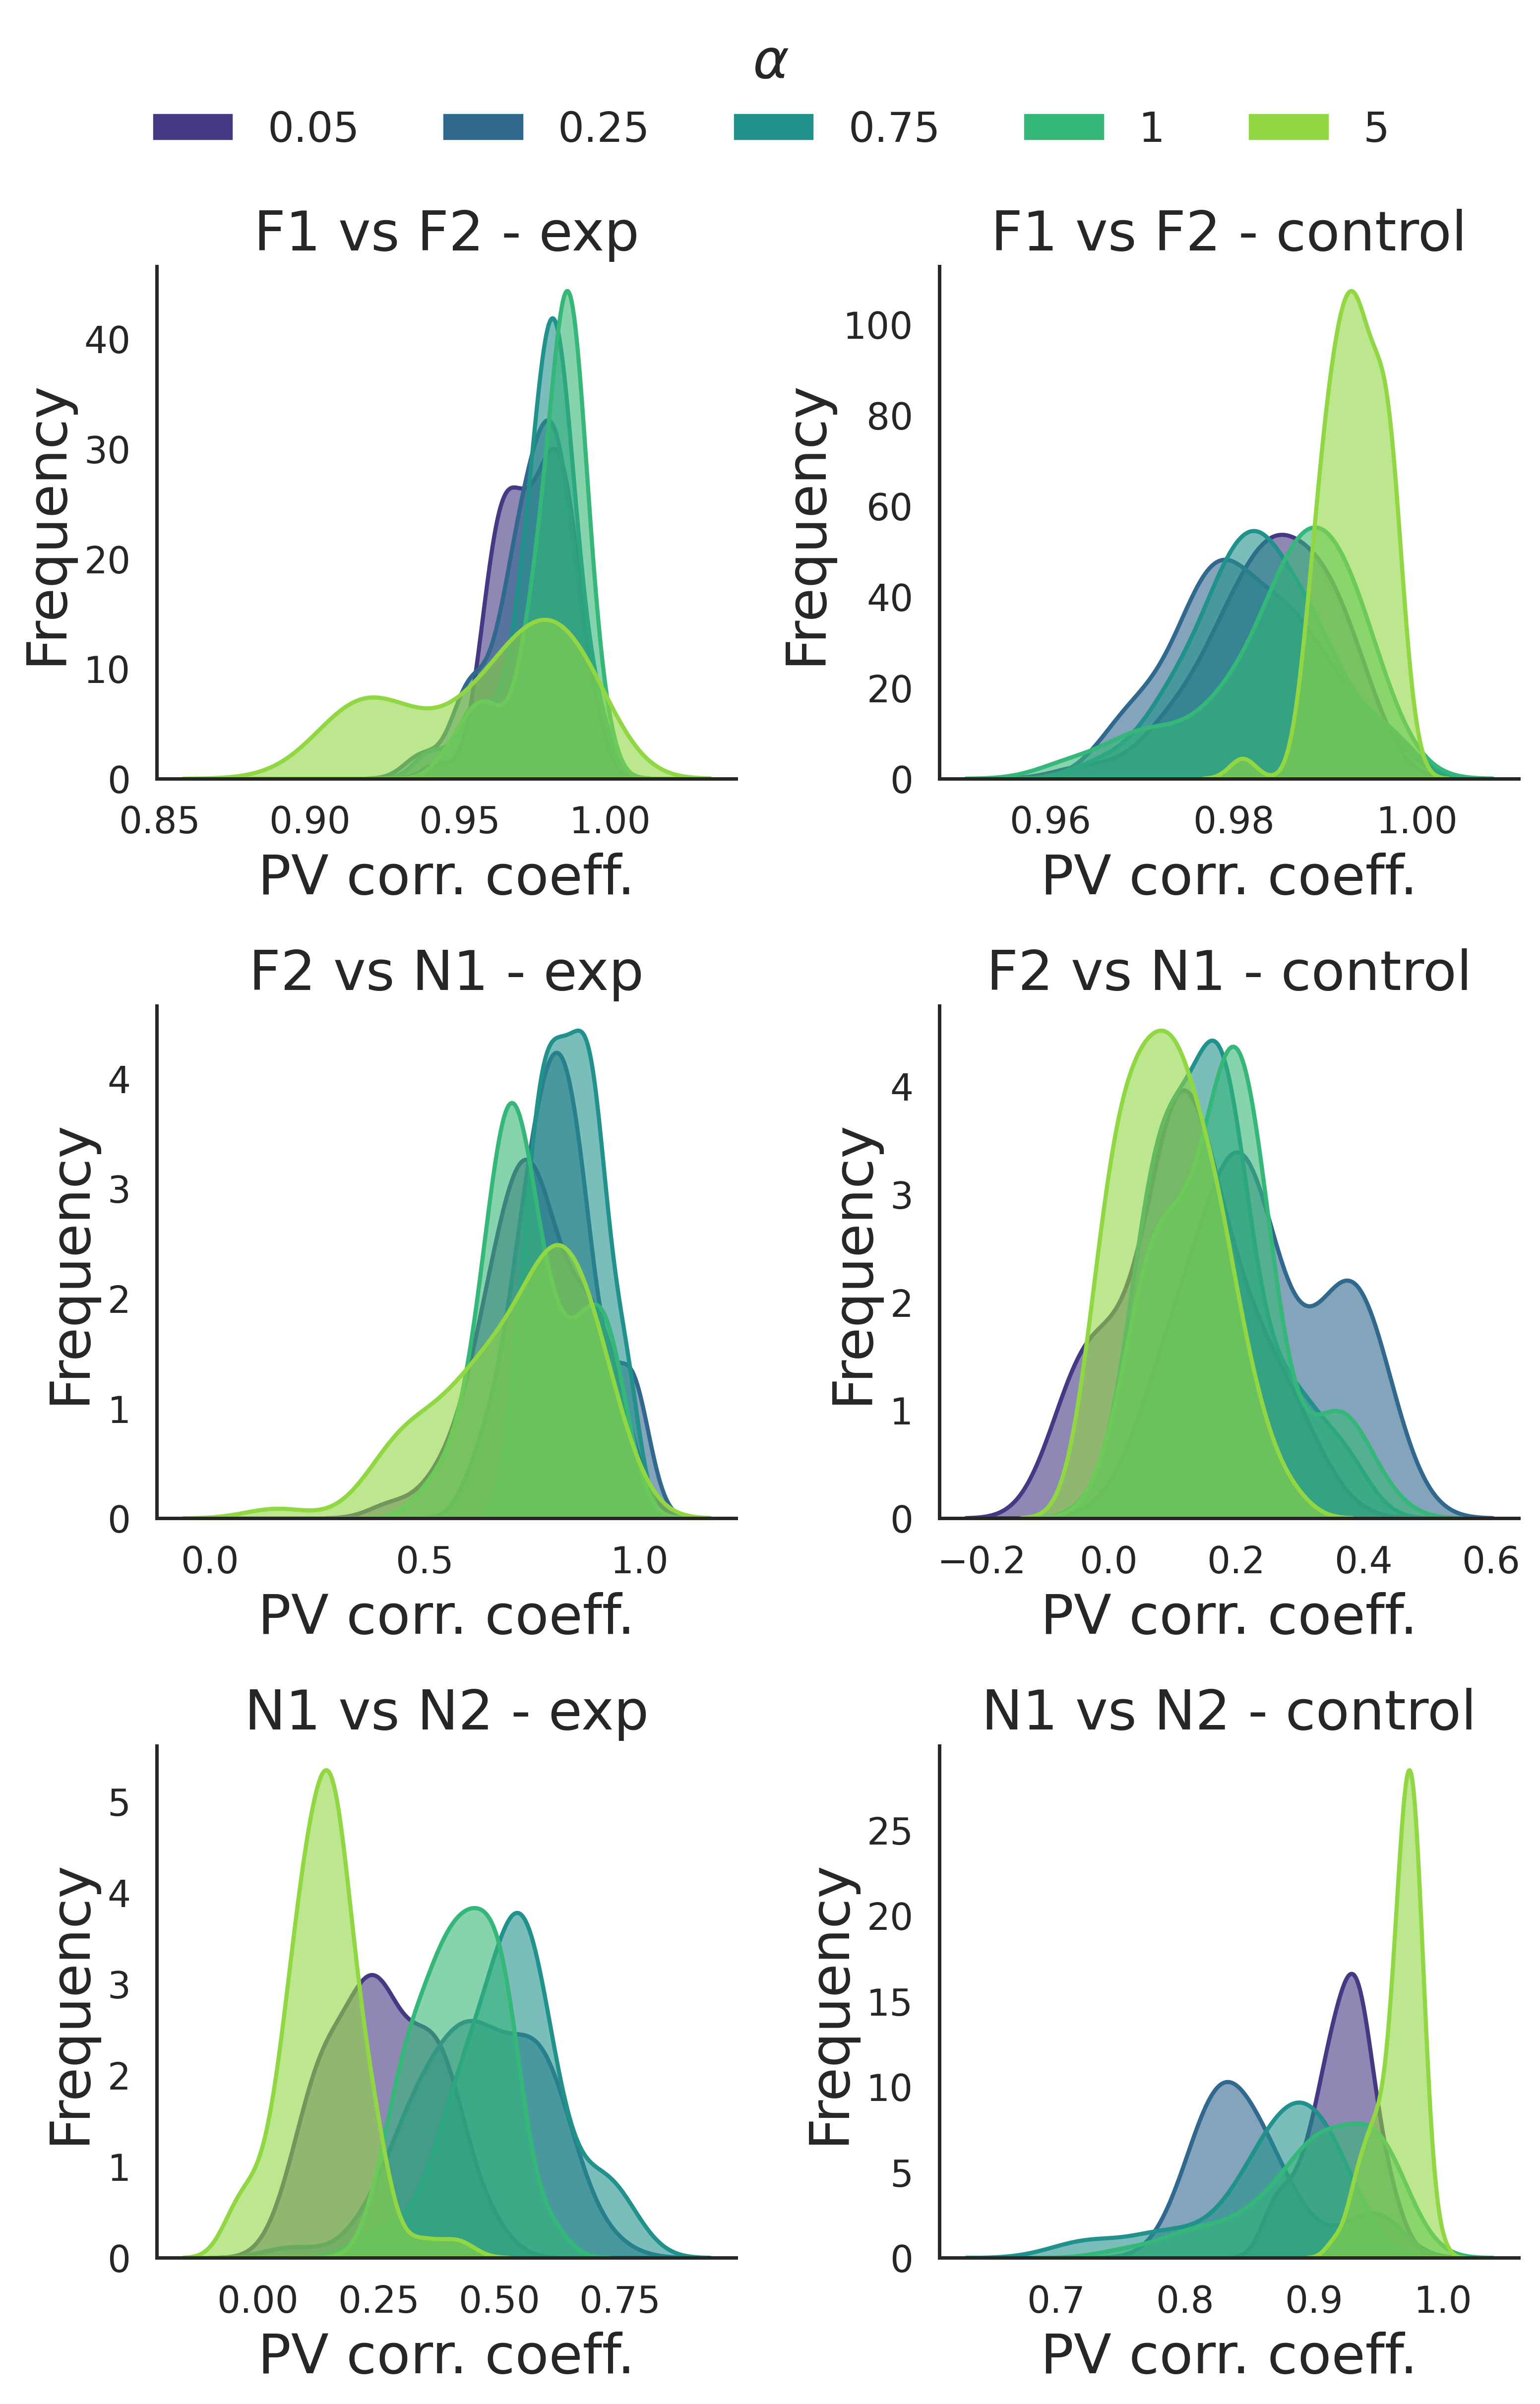

In [ ]:
## plot parameter variations

params = {
        'lr': [0.1, 1, 10, 100, 1000],
        'lr_inh': [0.1, 1, 10, 100, 1000],
        'alpha': [0.05, 0.25, 0.75, 1, 5],
    }

param_names = {
    'lr': r'$\eta$',
    'lr_inh': r'$\eta_{inh}$',
    'alpha': r'$\alpha$',
}

pvs_per_param = {}

for param, values in params.items():
    pvs_per_param[param] = {}

    for value in values:
        with open(f"simulations/data/1d_2envs/act_maps_and_pvs_inh_{param}_{value}.pkl", 'rb') as f:
            amp = pickle.load(f)

        pvs_per_param[param][value] = (amp['pvs_per_condition']['exp'], amp['pvs_per_condition']['control'])


for param_idx, param in enumerate(params.keys()):
    fig, axs = plt.subplots(3, 2, figsize=(8, 12), dpi=400)  ## TODO: Maybe Instead i will do 3 plots of 3x2 but let's see how this looks first
    for con_idx, condition in enumerate(['exp', 'control']):
        for i, comp in enumerate([('F1', 'F2'), ('F2', 'N1'), ('N1', 'N2')]):

            ax = axs[i, con_idx]
            
            all_pvs = []
            for value in params[param]:
                pvs = pvs_per_param[param][value][con_idx][i]
                all_pvs.append(pvs)

            colors = sns.color_palette("viridis", len(all_pvs))
            plot_pv_corr_distributions(all_pvs, out1=comp[0], out2=f'{comp[1]} - {condition}',
                                       ax=ax, p=None, colors=colors)

    # Create shared legend
    legend_elements = [
        Patch(facecolor=colors[i], label=params[param][i]) for i in range(len(colors))
    ]

    fig.legend(
        handles=legend_elements,
        title=param_names[param],
        loc='upper center',
        bbox_to_anchor=(0.5, 1.02),
        ncol=len(colors),
        fontsize=15,
        title_fontsize=20,
        frameon=False
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    

-0.07403965233466361 0.9332273098029207


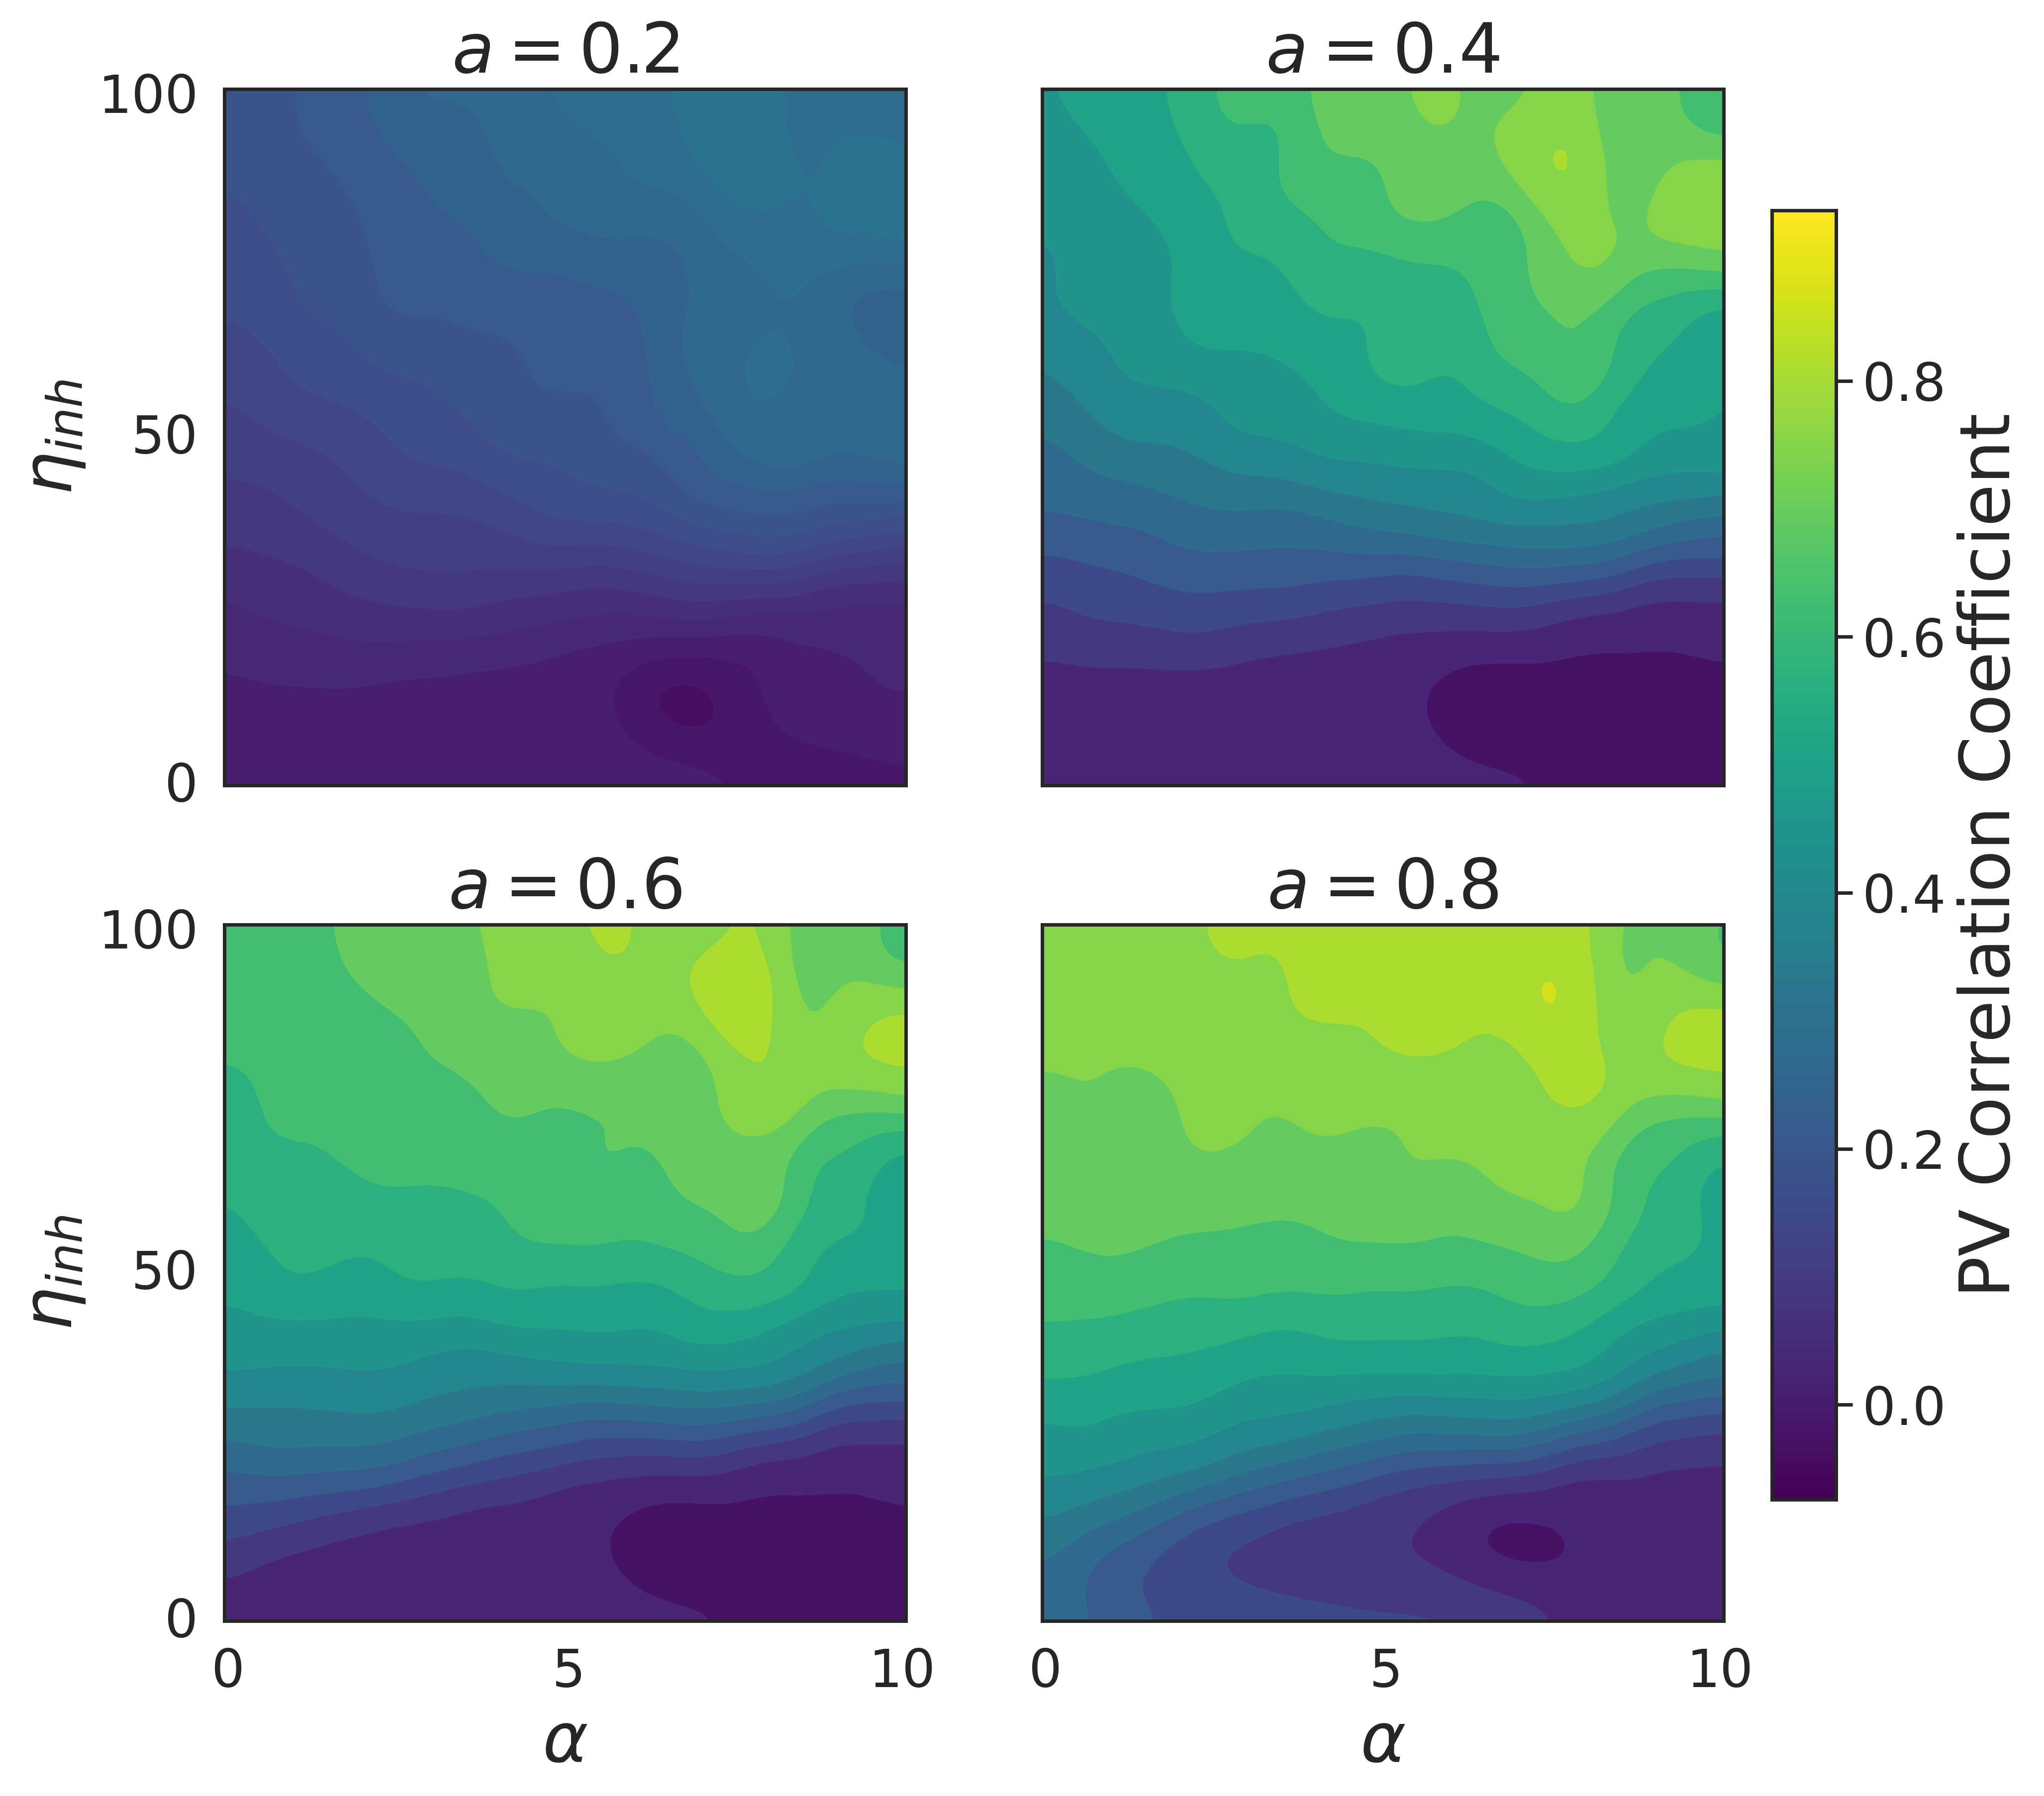

In [ ]:
### plot alpha and inh_lr parameter variations

lr_inhs = np.arange(0, 100, 1).round(1) 
alphas = np.arange(0, 10, .1).round(1)  
aas = [0.2, 0.4, 0.6, 0.8]  

outs = {}

for a in aas:
    out = np.zeros((len(lr_inhs), len(alphas)))
    for i, lr_inh in enumerate(lr_inhs):
        for j, alpha in enumerate(alphas):
            out_file = f'simulations/data/test_plast/{a}/pv_corr_lr_inh_{lr_inh}_alpha_{alpha}.pkl'
            with open(out_file, 'rb') as f:
                pv_corr = pickle.load(f)
            mean_pv_corr = np.nanmean(pv_corr)
            out[i, j] = mean_pv_corr
    outs[a] = out

fs = 25

vmin = np.nanmin([np.nanmin(outs[a]) for a in aas])
vmax = np.nanmax([np.nanmax(outs[a]) for a in aas])

fig, axs = plt.subplots(len(aas)//2, len(aas)//2, figsize=(12, 10), sharey=True, sharex=True, dpi=400)
axs = axs.flatten()
axs[0].set_ylabel(r'$\eta_{inh}$', fontsize=fs)
axs[2].set_ylabel(r'$\eta_{inh}$', fontsize=fs)

for a, ax in zip(aas, axs):
    # Apply Gaussian smoothing to the output matrix
    out_smoothed = gaussian_filter(outs[a], sigma=4)

    im = ax.contourf(out_smoothed, cmap='viridis', vmax=vmax, vmin=vmin, levels=15,
                   extent=[alphas[0], alphas[-1], lr_inhs[-1], lr_inhs[0]], origin ='upper') #, interpolation='nearest')

    ax.set_title(fr'$a = {a}$', fontsize=fs)
    if a == aas[-1] or a == aas[-2]:
        ax.set_xlabel(r'$\alpha$', fontsize=fs)
    if a == aas[0] or a == aas[2]:
        ax.set_yticks([1, 50, 98])
        ax.set_yticklabels([0, 50, 100], fontsize=fs//1.3)

    ax.set_xticks([.1, 5, 9.8])
    ax.set_xticklabels([0, 5, 10], fontsize=fs//1.3)


plt.subplots_adjust(right=0.8)  # Make space for colorbar
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax)),
    ax=axs,
    orientation='vertical',
    fraction=0.04,  # increased from 0.02 to make it bigger
    pad=0.03,
)
cbar.set_label('PV Correlation Coefficient', fontsize=fs)
cbar.ax.tick_params(labelsize=fs//1.3)
plt.show()

